In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [4]:
from clustering.utils import *

Warum Modellierung?: Prüfen ob Cluster irgendeinen causalen Effekt auf Hospitalisierungen haben 
Mehrere Möglichkeiten:
- Visueller Vergleich zwischen e.g. Cluster Percentage & R-Wert/Hospitalisierungen
- Cluster Percentage als Input für das Modell (Gesamtzeitraum - eig. kein Train-Test Split benötigt)
- Erstmal Linear um Zusammenhang festzustellen
- Dann: Verbindung vermutlich nicht linear --> daher Neuronales Netz
- Abschließend ggf. Vergleich unsere Daten (Cluster oder Faktordaten) vs. Mobility Daten —> ist es ein alternativer Prediktor?

# Experiments
To Do: Model specific score with 1 cluster

In [5]:
restart_experiments = False
n_iterations = 10
methods = ['gmm_full', 'gmm_tied', 'gmm_diag', 'gmm_spherical', 'kmeans', 'nnmf'] #
list_n_cluster = np.arange(1,8,1)
#if restart_experiments:
#  random_seeds = np.random.randint(high=200, low=1, size=n_iterations)
#else:
random_seeds = np.array([51, 108,  75, 134,  26,  55,  74, 118, 128,  54])
random_seeds

array([ 51, 108,  75, 134,  26,  55,  74, 118, 128,  54])

In [6]:
#dict_results[Iteration]['Method'][Cluster_number]['Score']
if restart_experiments:
  # Create Empty Dictionary
  dict_results = {}
  for i in np.arange(n_iterations):
    dict_results_iteration = {}
    for method in methods:
      dict_temp = {}
      for n_cluster in list_n_cluster:
        dict_entry = {'silhouette_score': np.nan, 'ch_score': np.nan, 'db_score': np.nan, 'model_specific_score': np.nan}
        dict_temp.update({n_cluster:dict_entry})
      dict_results_iteration.update({method: dict_temp})
    dict_results.update({i:dict_results_iteration})

In [7]:
if restart_experiments:
  cov_type='full'
  # Experiments
  for i in np.arange(n_iterations):
    random_seed = random_seeds[i]
    for method in methods:
      method_name = method
      if method[:3]=='gmm':
        method_name = method.rsplit('_')[0]
        cov_type = method.rsplit('_')[1]
      for n_cluster in list_n_cluster:
        answers, labels, model_specific_score = get_cluster_data_experiments(n_cluster=n_cluster, method=method_name, cov_type=cov_type, random_seed=random_seed, cluster_input_data='fa_data', start_train='2020-07-31', end_train='2020-12-01')
        dict_results[i][method][n_cluster]['model_specific_score'] = model_specific_score
        if n_cluster > 1:
          dict_results[i][method][n_cluster]['silhouette_score'] = metrics.silhouette_score(answers, labels, metric='euclidean')
          dict_results[i][method][n_cluster]['ch_score'] = metrics.calinski_harabasz_score(answers, labels)
          dict_results[i][method][n_cluster]['db_score'] = metrics.davies_bouldin_score(answers, labels)
        

In [8]:
if restart_experiments:
  # Transform Dictionary to DataFrame
  df_results = pd.DataFrame(columns=['iteration', 'random_seed', 'method', 'number_cluster', 'silhouette_score', 'ch_score', 'model_specific_score'])
  for i in np.arange(n_iterations):
    for method in methods:
      df_temp = pd.DataFrame.from_dict(dict_results[i][method], orient='index')
      df_temp['iteration'] = i
      df_temp['random_seed'] = random_seeds[i]
      df_temp['number_cluster'] = df_temp.index
      df_temp['method'] = method
      df_results = df_results.append(df_temp)
  df_results.reset_index(inplace=True, drop=True)
  df_results.to_csv('data/clustering/results/results_clustering.csv', index=False)
  df_results.head()

In [9]:
if restart_experiments:
  df_results_agg = df_results.groupby(['method', 'number_cluster']).mean().reset_index()
  df_results_std = df_results.groupby(['method', 'number_cluster']).std().reset_index()
  avg_col_list = df_results_agg.columns[2:].to_list()
  for element in avg_col_list:
    df_results_agg.rename(columns={element: element+'_avg'}, inplace=True)
    df_results_agg[element + '_std'] = df_results_std[element]
  df_results_agg.to_csv('data/clustering/results/results_clustering_agg.csv', index=False)
  df_results_agg.head()

In [10]:
if restart_experiments == False:
  df_results = pd.read_csv('data/clustering/results/results_clustering.csv')
  df_results_agg = pd.read_csv('data/clustering/results/results_clustering_agg.csv')

In [11]:
df_max = df_results.groupby(by=['method', 'number_cluster']).max().reset_index().drop(columns=['iteration', 'random_seed'])
df_max.sort_values(by=['number_cluster', 'silhouette_score'], ascending=False)

,method,number_cluster,silhouette_score,ch_score,model_specific_score,db_score
34,kmeans,7,0.178659,9936.410611,3344.602070,1.457878
20,gmm_spherical,7,0.162746,9164.852106,-81107.696546,1.568363
27,gmm_tied,7,0.156697,6930.159684,-84821.512977,1.663626
41,nnmf,7,0.126473,6964.750376,0.694236,4.273222
6,gmm_diag,7,0.044826,4856.014750,-131578.430910,2.889546
13,gmm_full,7,0.028985,4426.725582,-133312.578985,3.332121
33,kmeans,6,0.173810,10462.892864,3588.492069,1.521661
19,gmm_spherical,6,0.161966,9392.929055,-79210.500631,1.626596
26,gmm_tied,6,0.158820,7413.303699,-84726.755239,1.612400
40,nnmf,6,0.138558,7484.393554,0.793124,3.214466


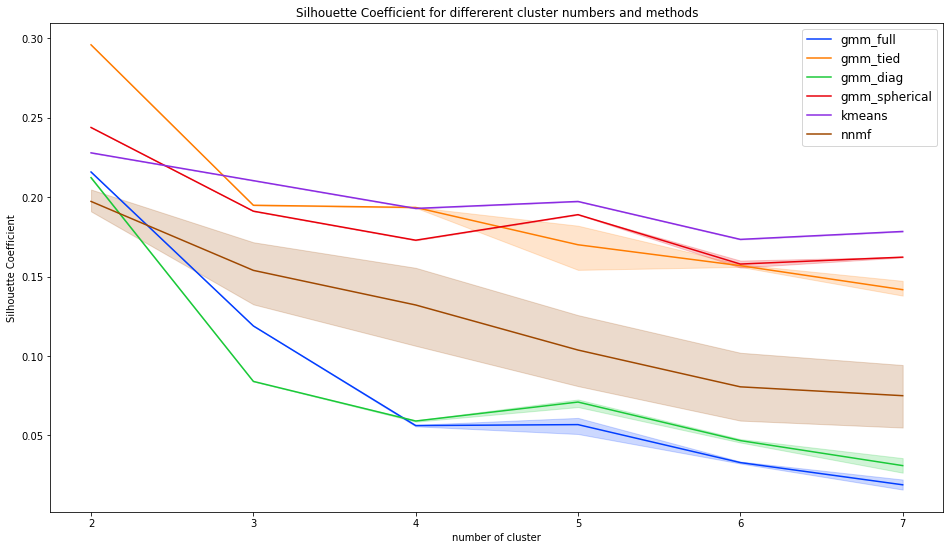

In [43]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df_results, x='number_cluster', y='silhouette_score', hue='method', palette='bright') # Close to 1
plt.title('Silhouette Coefficient for differerent cluster numbers and methods')
ax.legend(loc='best', fontsize='large')
ax.set_ylabel('Silhouette Coefficient')
ax.set_xlabel('number of cluster')
fig.savefig("images/clustering_silhouette_scores.png")
plt.show()

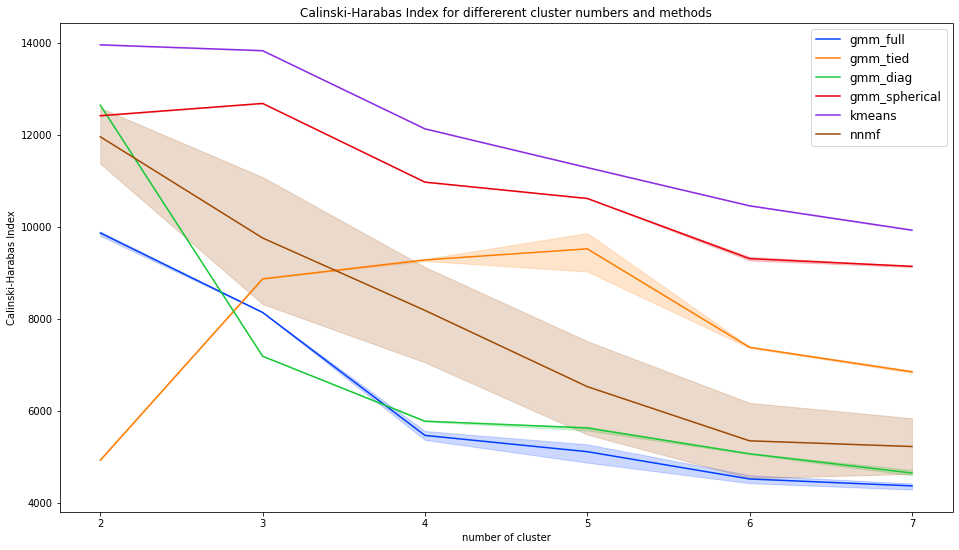

In [42]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df_results, x='number_cluster', y='ch_score', hue='method', palette='bright') # Maximize
plt.title('Calinski-Harabas Index for differerent cluster numbers and methods')
ax.legend(loc='best', fontsize='large')
ax.set_ylabel('Calinski-Harabas Index')
ax.set_xlabel('number of cluster')
fig.savefig("images/clustering_ch_scores.png")
plt.show()

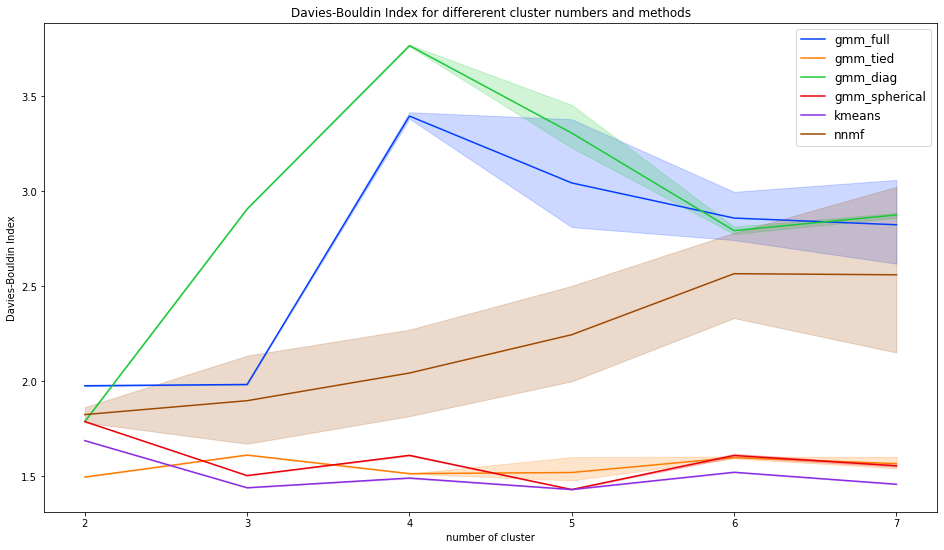

In [41]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df_results, x='number_cluster', y='db_score', hue='method', palette='bright') # close to zero
plt.title('Davies-Bouldin Index for differerent cluster numbers and methods')
ax.legend(loc='best', fontsize='large')
ax.set_ylabel('Davies-Bouldin Index')
ax.set_xlabel('number of cluster')
fig.savefig("images/clustering_db_scores.png")
plt.show()

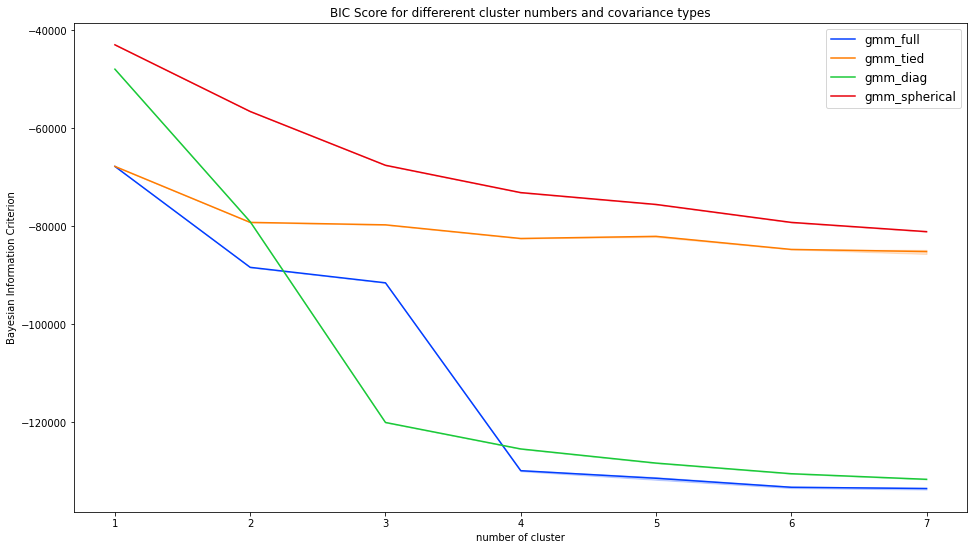

In [46]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df_results[(df_results['method']!='kmeans') & (df_results['method']!='nnmf')], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # BIC - Minimize / find elbow
plt.title('BIC Score for differerent cluster numbers and covariance types')
ax.legend(loc='best', fontsize='large')
ax.set_ylabel('Bayesian Information Criterion')
ax.set_xlabel('number of cluster')
fig.savefig("images/clustering_BIC_scores.png")
plt.show()

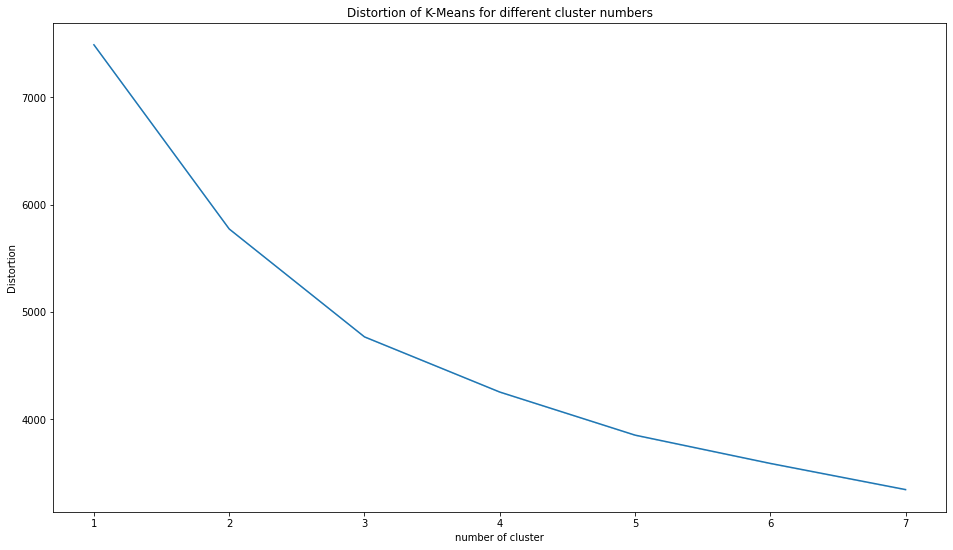

In [51]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df_results[df_results['method']=='kmeans'], x='number_cluster', y='model_specific_score') # Find elbow
plt.title('Distortion of K-Means for different cluster numbers')
ax.set_ylabel('Distortion')
ax.set_xlabel('number of cluster')
fig.savefig("images/clustering_distortion_kmeans.png")
plt.show()

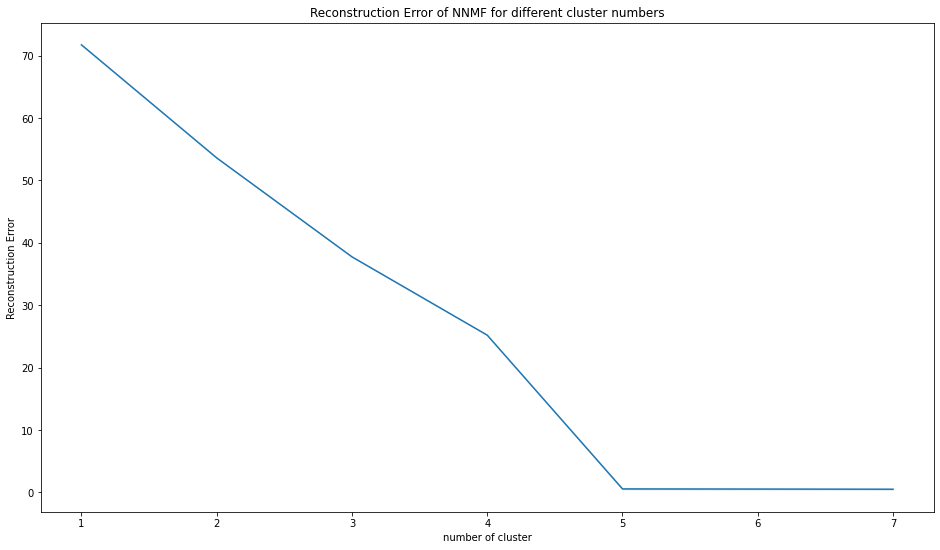

In [50]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df_results[df_results['method']=='nnmf'], x='number_cluster', y='model_specific_score') # Find elbow
plt.title('Reconstruction Error of NNMF for different cluster numbers')
ax.set_ylabel('Reconstruction Error')
ax.set_xlabel('number of cluster')
fig.savefig("images/clustering_recerror_nnmf.png")
plt.show()

# Calculate Ranking

In [18]:
df_results_agg[df_results_agg['number_cluster']==2].sort_values(by='silhouette_score_avg', ascending=False)#.iloc[0]

,method,number_cluster,silhouette_score_avg,ch_score_avg,model_specific_score_avg,db_score_avg,silhouette_score_std,ch_score_std,model_specific_score_std,db_score_std
22,gmm_tied,2,0.295951,4927.425463,-79226.184699,1.494704,0.000012,0.320769,0.273547,0.000005
15,gmm_spherical,2,0.243903,12415.581776,-56608.591871,1.787050,0.000097,1.723266,0.498366,0.000321
29,kmeans,2,0.227935,13956.130587,5772.417959,1.686561,0.000090,0.390644,0.007216,0.000211
8,gmm_full,2,0.215866,9866.396664,-88390.683790,1.975559,0.000379,97.984360,3.085209,0.007377
1,gmm_diag,2,0.212308,12644.190176,-79086.893892,1.787392,0.000663,12.001827,15.478256,0.001393
36,nnmf,2,0.197332,11957.733253,53.600467,1.823710,0.012309,1051.608075,0.000991,0.071407


In [19]:
n_inits = df_results_agg.shape[0] / len(methods)
ranking = []
for i in np.arange(n_inits):
  temp = np.arange(0, len(methods),1).tolist()
  ranking = ranking + temp

In [20]:
df_ranking = df_results_agg.sort_values(by=['number_cluster', 'silhouette_score_avg'])
df_ranking['ranking_silhouette'] = ranking
df_ranking.sort_values(by=['number_cluster', 'ch_score_avg'], inplace=True)
df_ranking['ranking_ch'] = ranking
df_ranking.sort_values(by=['number_cluster', 'db_score_avg'], inplace=True, ascending=False)
df_ranking['ranking_db'] = ranking
df_ranking = df_ranking.sort_values(by=['number_cluster', 'method']).reset_index(drop=True)
df_ranking['avg_ranking'] = df_ranking[['ranking_silhouette', 'ranking_ch', 'ranking_db']].mean(axis=1)
df_ranking.sort_values(by=['number_cluster', 'avg_ranking'], ascending=False)

,method,number_cluster,silhouette_score_avg,ch_score_avg,model_specific_score_avg,db_score_avg,silhouette_score_std,ch_score_std,model_specific_score_std,db_score_std,ranking_silhouette,ranking_ch,ranking_db,avg_ranking
40,kmeans,7,0.178427,9928.353292,3344.502897,1.456847,0.000279,10.871985,5.002355e-02,0.001314,5,5,5,5.000000
38,gmm_spherical,7,0.162242,9141.133213,-81111.769074,1.553992,0.000326,23.629188,3.926319e+00,0.008469,4,4,4,4.000000
39,gmm_tied,7,0.141767,6847.415922,-85174.748791,1.565248,0.007821,41.333729,7.077577e+02,0.050998,3,3,3,3.000000
41,nnmf,7,0.075007,5224.467771,0.491477,2.560157,0.034607,1089.377334,9.635073e-02,0.746380,2,2,2,2.000000
36,gmm_diag,7,0.030980,4648.372602,-131620.111027,2.875456,0.007817,100.579941,5.187331e+01,0.020696,1,1,0,0.666667
37,gmm_full,7,0.018901,4368.593313,-133497.697657,2.823747,0.005251,117.976772,3.198014e+02,0.375876,0,0,1,0.333333
34,kmeans,6,0.173436,10457.006480,3588.323134,1.519929,0.000304,4.313070,9.991074e-02,0.000951,5,5,5,5.000000
32,gmm_spherical,6,0.157896,9308.179354,-79227.026819,1.608226,0.003709,67.974836,1.271374e+01,0.015784,4,4,3,3.666667
33,gmm_tied,6,0.156879,7380.706639,-84739.370443,1.597225,0.001417,25.601528,9.899922e+00,0.009122,3,3,4,3.333333
35,nnmf,6,0.080583,5347.859179,0.518517,2.565942,0.035264,1381.607446,1.170734e-01,0.391896,2,2,2,2.000000


In [21]:
for n in list_n_cluster:
  top = df_ranking[df_ranking['number_cluster'] == n].sort_values(by='avg_ranking', ascending=False).iloc[0]
  print(str(n) + ' Cluster - best method: ' + top['method'] + ' with an average score of ' + str(top['avg_ranking']))

1 Cluster - best method: nnmf with an average score of 5.0
2 Cluster - best method: kmeans with an average score of 4.0
3 Cluster - best method: kmeans with an average score of 5.0
4 Cluster - best method: kmeans with an average score of 4.666666666666667
5 Cluster - best method: kmeans with an average score of 4.666666666666667
6 Cluster - best method: kmeans with an average score of 5.0
7 Cluster - best method: kmeans with an average score of 5.0


In [53]:
df_ranking.columns

Index(['method', 'number_cluster', 'silhouette_score_avg', 'ch_score_avg',
       'model_specific_score_avg', 'db_score_avg', 'silhouette_score_std',
       'ch_score_std', 'model_specific_score_std', 'db_score_std',
       'ranking_silhouette', 'ranking_ch', 'ranking_db', 'avg_ranking'],
      dtype='object')

In [59]:
relevant_columns = ['method', 'silhouette_score_avg', 'ranking_silhouette', 'ch_score_avg', 'ranking_ch', 'db_score_avg', 'ranking_db', 'avg_ranking']
relevant_cluster_number = 2
df_decision_method = df_ranking[relevant_columns][df_ranking['number_cluster'] == relevant_cluster_number].sort_values(by='avg_ranking', ascending=False).reset_index(drop=True)
df_decision_method

,method,silhouette_score_avg,ranking_silhouette,ch_score_avg,ranking_ch,db_score_avg,ranking_db,avg_ranking
0,kmeans,0.227935,3,13956.130587,5,1.686561,4,4.000000
1,gmm_spherical,0.243903,4,12415.581776,3,1.787050,3,3.333333
2,gmm_tied,0.295951,5,4927.425463,0,1.494704,5,3.333333
3,gmm_diag,0.212308,1,12644.190176,4,1.787392,2,2.333333
4,gmm_full,0.215866,2,9866.396664,1,1.975559,0,1.000000
5,nnmf,0.197332,0,11957.733253,2,1.823710,1,1.000000


# Test Rand Score

In [22]:
#dict_rand_scores[iteration][number_cluster] - avg_rand_score

In [6]:
# Create empty dict
dict_rand_scores = {}
for i in np.arange(n_iterations):
  dict_temp = {}
  for n_cluster in list_n_cluster:
    dict_temp.update({n_cluster: np.nan})
  dict_rand_scores.update({i: dict_temp})
dict_rand_scores

{0: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 1: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 2: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 3: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 4: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 5: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 6: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 7: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 8: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 9: {1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan}}

In [7]:
# Calc Rand Scores
for i in np.arange(n_iterations):
  random_seed = random_seeds[i]
  for n_cluster in list_n_cluster:
    cum_rand_scores = 0
    for method_1 in methods:
      df_1 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_1 +'_' + str(n_cluster) + '.csv')
      labels_1 = df_1['group'].to_numpy()
      for method_2 in methods:
        df_2 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_2 +'_' + str(n_cluster) + '.csv')
        labels_2 = df_2['group'].to_numpy()
        rand_score = metrics.adjusted_rand_score(labels_1, labels_2)
        
        #print(str(n_cluster) + ' Cluster - Comparing ' + method_1 + ' with ' + method_2 + ' - Rand Score: ' + str(rand_score))
        cum_rand_scores = cum_rand_scores + rand_score
    avg_rand_score = (cum_rand_scores-len(methods)) / ((len(methods)-1)*len(methods))
    dict_rand_scores[i][n_cluster] = avg_rand_score
    print(str(n_cluster) + ' Cluster with average rand score: ' + str(avg_rand_score))

1 Cluster with average rand score: 1.0
2 Cluster with average rand score: 0.34011664201187825
3 Cluster with average rand score: 0.2142185344387082
4 Cluster with average rand score: 0.25573877171689396
5 Cluster with average rand score: 0.19806846962811328
6 Cluster with average rand score: 0.18669938242992026
7 Cluster with average rand score: 0.2430868836509991
1 Cluster with average rand score: 1.0
2 Cluster with average rand score: 0.45826993873045163
3 Cluster with average rand score: 0.44155594931196696
4 Cluster with average rand score: 0.26520827024757193
5 Cluster with average rand score: 0.21346537903258497
6 Cluster with average rand score: 0.17607983966864302
7 Cluster with average rand score: 0.18798061258701107
1 Cluster with average rand score: 1.0
2 Cluster with average rand score: 0.17553654181785086
3 Cluster with average rand score: 0.4795185986510601
4 Cluster with average rand score: 0.21197643832190302
5 Cluster with average rand score: 0.16905759415204358
6 Clus

In [8]:
# Create DataFrames
df_rand_scores = pd.DataFrame.from_dict(dict_rand_scores)
df_rand_scores['n_cluster'] = df_rand_scores.index
df_rand_scores_plot = pd.melt(df_rand_scores, id_vars='n_cluster')
df_rand_scores_plot.rename(columns={'variable': 'iteration', 'value': 'rand_score'}, inplace=True)
for i in np.arange(n_iterations):
  df_rand_scores.rename(columns={i: 'rand_score_' + str(i)}, inplace=True)
df_rand_scores['avg_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').mean()
df_rand_scores['std_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').std()
df_rand_scores

,rand_score_0,rand_score_1,rand_score_2,rand_score_3,rand_score_4,rand_score_5,rand_score_6,rand_score_7,rand_score_8,rand_score_9,n_cluster,avg_rand_score,std_rand_score
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1,1.000000,0.000000
2,0.340117,0.458270,0.175537,0.282743,0.174613,0.151118,0.147751,0.544189,0.151604,0.158887,2,0.258483,0.144469
3,0.214219,0.441556,0.479519,0.414568,0.279607,0.241719,0.143249,0.143056,0.259624,0.273744,3,0.289086,0.118740
4,0.255739,0.265208,0.211976,0.242854,0.190934,0.140921,0.148777,0.188625,0.171485,0.179637,4,0.199616,0.043322
5,0.198068,0.213465,0.169058,0.177665,0.253153,0.181745,0.149069,0.234345,0.183296,0.218188,5,0.197805,0.031859
6,0.186699,0.176080,0.196515,0.176692,0.207518,0.107540,0.113872,0.182719,0.148462,0.145276,6,0.164137,0.034020
7,0.243087,0.187981,0.171589,0.212921,0.194086,0.162895,0.166139,0.222540,0.180592,0.197862,7,0.193969,0.025947


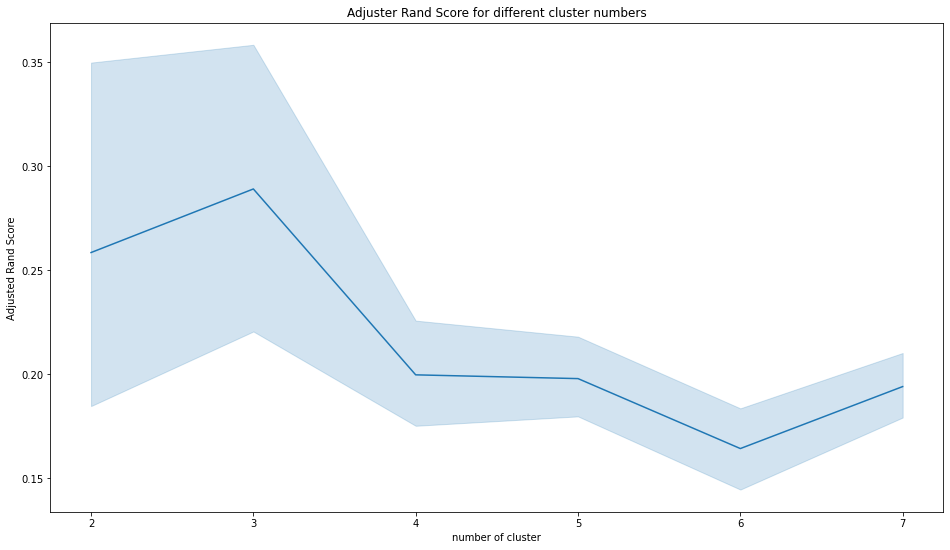

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(data=df_rand_scores_plot[df_rand_scores_plot['n_cluster'] != 1], x='n_cluster', y='rand_score')
plt.title('Adjuster Rand Score for different cluster numbers')
ax.set_ylabel('Adjusted Rand Score')
ax.set_xlabel('number of cluster')
fig.savefig("images/clustering_rand_score.png")
plt.show()